# BINARY CLASSIFICATION

##### XGBoost model 
##### annotation result 0, 1 (binary classification)
#####  mean()
##### class weights, medical choice, hyperparameter tuning

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('judge 제거_LCE.csv')

In [3]:
#import missingno as msno
#msno.bar(df)

In [4]:
df = df.dropna(axis=1, thresh=1)

## Preprocessing
#### 1. annotation result = 3, Null drop

In [5]:
# annotation result = 0, 1, 2 만 남기고 확인 

null_annot = list(np.where(df['annotation_result'].isna() == True)[0])
df = df.drop(null_annot, axis = 'index')
df.index = range(len(df))

three_annot = list(np.where(df['annotation_result'] == 3)[0])
df = df.drop(three_annot, axis = 'index')
df.index = range(len(df))

df['annotation_result'].unique()

array([1., 0., 2.])

In [6]:
zero = list(np.where(df['annotation_result'] == 0)[0])
one = list(np.where(df['annotation_result'] == 1)[0])
two = list(np.where(df['annotation_result'] == 2)[0])
df['annotation_result'][zero] = 0
df['annotation_result'][one] = 0
df['annotation_result'][two] = 1

df['annotation_result'].unique()

array([0., 1.])

## 결측치 mean(), train, test split

In [7]:
df = df.fillna(df.mean())

#최빈값
#df = df.fillna(df.mode().iloc[0])
#df

#중앙값
#df = df.fillna(df.median().iloc[0])
#df

In [8]:
# Select all columns except certain columns
X = df.iloc[:,7:]
y = np.ravel(df.loc[:, ['annotation_result']])

from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set: ", X_train.shape, y_train.shape)
print("Test set: ", X_test.shape, y_test.shape)

Training set:  (1427, 70) (1427,)
Test set:  (357, 70) (357,)


## Scaler 적용 

In [9]:
# 1. Standard Scaler
from sklearn.preprocessing import StandardScaler, RobustScaler, scale

# Initialize the StandardScaler
#standard_scaler = StandardScaler()
# Fit the scaler on the training data
#standard_scaler.fit(X_train)
# Scale the training, validation, and test data using the scaler
#X_train_standard = standard_scaler.transform(X_train)
#X_val_standard = standard_scaler.transform(X_val)
#X_test_standard = standard_scaler.transform(X_test)


# 2. Initialize the RobustScaler
robust_scaler = RobustScaler()
# Scale the training, validation, and test data using the scaler
X_train = robust_scaler.fit_transform(X_train)
X_test = robust_scaler.transform(X_test)

# ORIGINAL model

              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89       271
         1.0       0.73      0.42      0.53        86

    accuracy                           0.82       357
   macro avg       0.79      0.69      0.71       357
weighted avg       0.81      0.82      0.80       357



Text(0.5, 1.0, 'All + Original model')

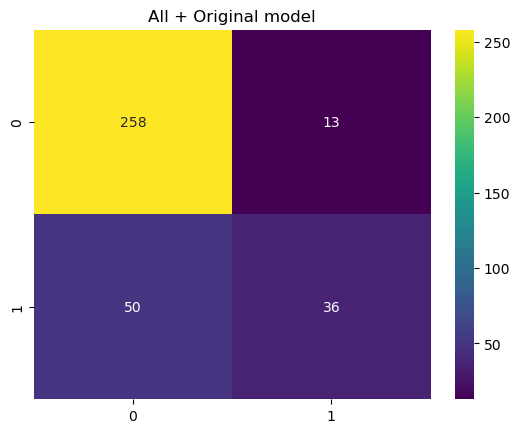

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model_original = XGBClassifier(random_state =42)
model_original.fit(X_train, y_train)

y_pred = model_original.predict(X_test)

# classification report 출력
print(classification_report(y_test, y_pred))

# confusion matrix 출력
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = 'd', cmap='viridis')
plt.title("All + Original model")

## Original + Tuning model

Best parameters found:  {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}
              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88       271
         1.0       0.64      0.42      0.51        86

    accuracy                           0.80       357
   macro avg       0.74      0.67      0.69       357
weighted avg       0.79      0.80      0.79       357



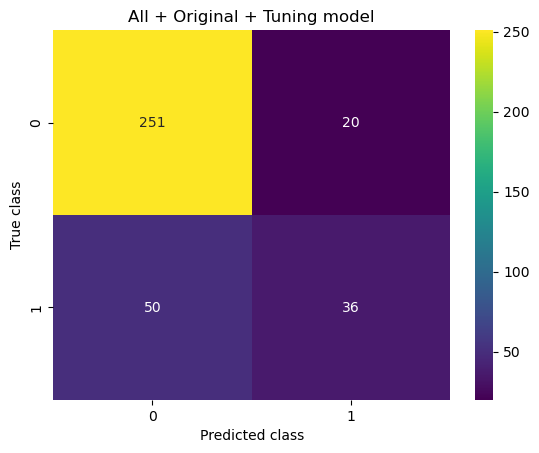

In [11]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define the hyperparameter grid to search
param_grid = {'n_estimators': [20, 50, 100, 200],
          'max_depth': [2, 3, 4, 5],
          'learning_rate': [0.01, 0.1, 0.2, 0.5]}

# GridSearchCV를 이용한 튜닝
grid_search = GridSearchCV(estimator=model_original, param_grid=param_grid, scoring ='f1', cv=5)
grid_search.fit(X, y)

# 최적의 hypaerparameter로 모델 생성 
best_model = XGBClassifier(**grid_search.best_params_, random_state =42)
print("Best parameters found: ", grid_search.best_params_)

# 모델 학습
best_model.fit(X_train, y_train)

# 예측 결과 출력
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = 'd', cmap="viridis")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("All + Original + Tuning model")
plt.show()

## Class weights model

              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89       271
         1.0       0.71      0.49      0.58        86

    accuracy                           0.83       357
   macro avg       0.78      0.71      0.74       357
weighted avg       0.82      0.83      0.82       357



Text(0.5, 1.0, 'All + weights model')

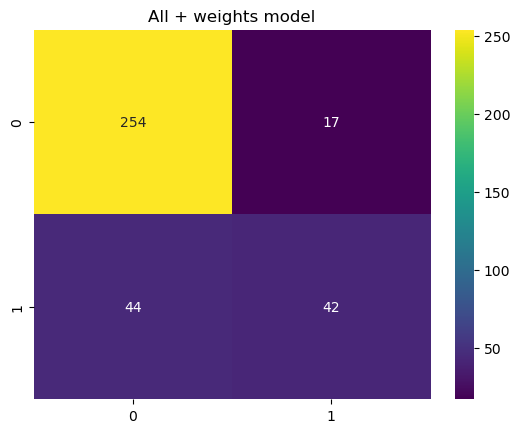

In [12]:
pos_ratio = sum(y_train == 0) / sum(y_train == 1)

# XGBoost 모델 인스턴스화
model_weights = XGBClassifier(
    scale_pos_weight = pos_ratio,
    random_state =42
)

model_weights.fit(X_train, y_train)

y_pred_weight = model_weights.predict(X_test)

print(classification_report(y_test, y_pred_weight))

cm = confusion_matrix(y_test, y_pred_weight)
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'viridis')
plt.title("All + weights model")

## Class weights + Tuning model

Best parameters found:  {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}
              precision    recall  f1-score   support

         0.0       0.81      0.97      0.88       271
         1.0       0.74      0.30      0.43        86

    accuracy                           0.81       357
   macro avg       0.78      0.63      0.66       357
weighted avg       0.80      0.81      0.77       357



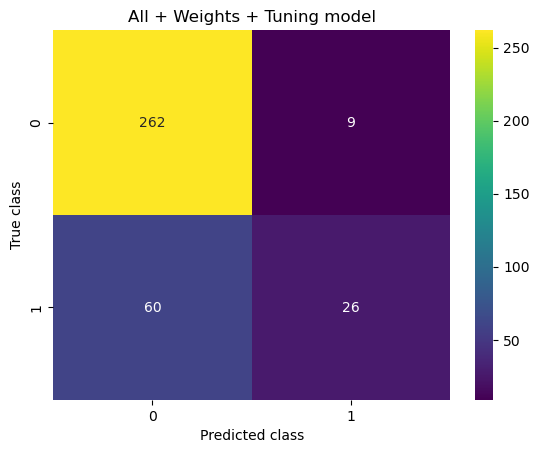

In [13]:
# GridSearchCV를 이용한 튜닝
grid_search_wt = GridSearchCV(estimator=model_weights, param_grid=param_grid, scoring ='f1', cv=5)
grid_search_wt.fit(X, y)


# 최적의 hypaerparameter로 모델 생성 
best_model_wt = XGBClassifier(**grid_search_wt.best_params_, random_state =42)
print("Best parameters found: ", grid_search.best_params_)

# 모델 학습
best_model_wt.fit(X_train, y_train)

# 예측 결과 출력
y_pred_wt = best_model_wt.predict(X_test)
print(classification_report(y_test, y_pred_wt))

# Plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred_wt)
sns.heatmap(cm, annot=True, fmt = 'd', cmap="viridis")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("All + Weights + Tuning model")
plt.show()

## Med Selection

In [14]:
# Select all columns except certain columns
X_MED = df.loc[:,['H103','X106','X105','X103','X104','X102','T102','L620','L621','T103','L622','L623',
              'P006','N817','C408','E512','S469','H105','H121','C102','C110','C104','C119',
             'C120','C121','C122','C401','E406','E403','Z977','C153','K087','K086','E427','C404',
             'L464']]
y_MED = np.ravel(df.loc[:, ['annotation_result']])

from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
X_train_MED, X_test_MED, y_train_MED, y_test_MED = train_test_split(X_MED, y_MED, test_size=0.2, random_state=42)

print("Training set: ", X_train_MED.shape, y_train_MED.shape)
print("Test set: ", X_test_MED.shape, y_test_MED.shape)

Training set:  (1427, 36) (1427,)
Test set:  (357, 36) (357,)


## Scaler

In [15]:
# 1. Standard Scaler
from sklearn.preprocessing import StandardScaler, RobustScaler, scale

# Initialize the StandardScaler
#standard_scaler = StandardScaler()
# Fit the scaler on the training data
#standard_scaler.fit(X_train)
# Scale the training, validation, and test data using the scaler
#X_train_standard = standard_scaler.transform(X_train)
#X_val_standard = standard_scaler.transform(X_val)
#X_test_standard = standard_scaler.transform(X_test)


# 2. Initialize the RobustScaler
robust_scaler = RobustScaler()
# Scale the training, validation, and test data using the scaler
X_train_MED = robust_scaler.fit_transform(X_train_MED)
X_test_MED = robust_scaler.transform(X_test_MED)

              precision    recall  f1-score   support

         0.0       0.83      0.95      0.89       271
         1.0       0.71      0.40      0.51        86

    accuracy                           0.82       357
   macro avg       0.77      0.67      0.70       357
weighted avg       0.80      0.82      0.79       357



Text(0.5, 1.0, 'MED model')

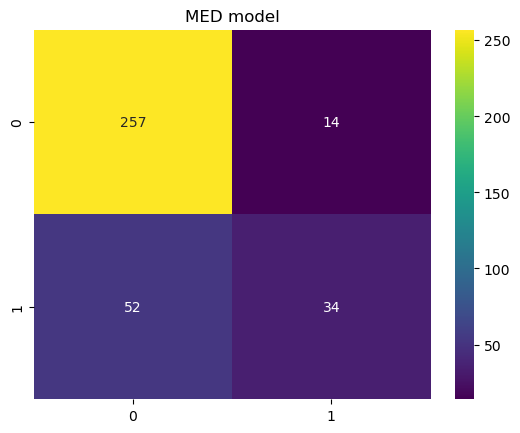

In [16]:
# XGBoost 모델 인스턴스화
model_MED = XGBClassifier(random_state =42)

# 모델 학습 시 class_weight에 class_weights를 전달
model_MED.fit(X_train_MED, y_train_MED)

y_pred_MED = model_MED.predict(X_test_MED)

print(classification_report(y_test_MED, y_pred_MED))

cm = confusion_matrix(y_test_MED, y_pred_MED)
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'viridis')
plt.title("MED model")

## Med selection + Tuning model

Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89       271
         1.0       0.75      0.38      0.51        86

    accuracy                           0.82       357
   macro avg       0.79      0.67      0.70       357
weighted avg       0.81      0.82      0.80       357



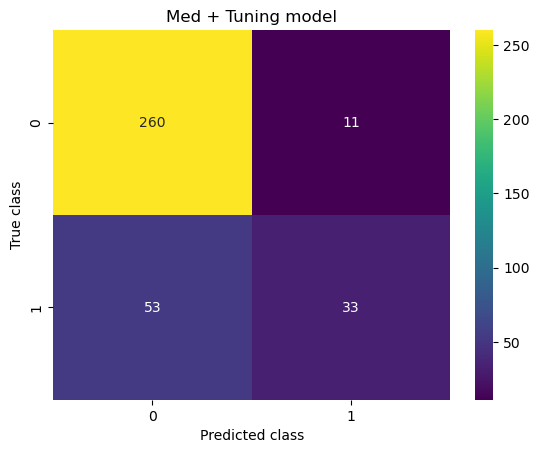

In [17]:
# GridSearchCV를 이용한 튜닝
grid_search_MED = GridSearchCV(estimator=model_MED, param_grid=param_grid, scoring ='f1', cv=5)
grid_search_MED.fit(X_MED, y_MED)

# 최적의 hypaerparameter로 모델 생성 
best_model_MED = XGBClassifier(**grid_search_MED.best_params_, random_state =42)
print("Best hyperparameters: ", grid_search_MED.best_params_)

# 모델 학습
best_model_MED.fit(X_train_MED, y_train_MED)

# 예측 결과 출력
y_pred_MED = best_model_MED.predict(X_test_MED)
print(classification_report(y_test_MED, y_pred_MED))

# Plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test_MED, y_pred_MED)
sns.heatmap(cm, annot=True, fmt = 'd', cmap="viridis")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Med + Tuning model")
plt.show()

# Med Selection + Class weights model 

              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87       271
         1.0       0.59      0.38      0.46        86

    accuracy                           0.79       357
   macro avg       0.71      0.65      0.67       357
weighted avg       0.77      0.79      0.77       357



Text(0.5, 1.0, 'MED + weights model')

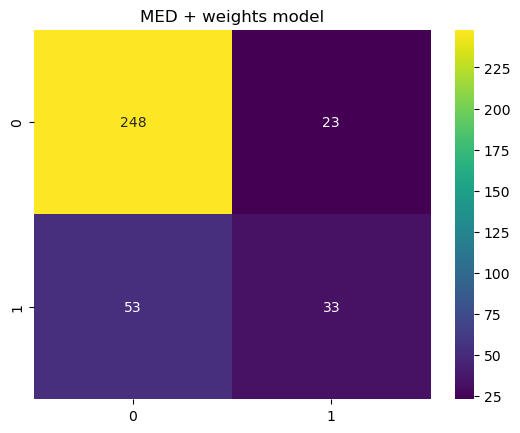

In [18]:
pos_ratio_MW = sum(y_train_MED == 0) / sum(y_train_MED == 1)

# XGBoost 모델 인스턴스화
model_MW = XGBClassifier(
    scale_pos_weight = pos_ratio_MW,
    random_state =42
)

# 모델 학습 시 class_weight에 class_weights를 전달
model_MW.fit(X_train_MED, y_train_MED)

y_pred_MW = model_MW.predict(X_test_MED)

print(classification_report(y_test_MED, y_pred_MW))

cm = confusion_matrix(y_test_MED, y_pred_MW)
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'viridis')
plt.title("MED + weights model")

# Med selection + Weights + Tuning model

Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88       271
         1.0       0.67      0.34      0.45        86

    accuracy                           0.80       357
   macro avg       0.75      0.64      0.66       357
weighted avg       0.78      0.80      0.78       357



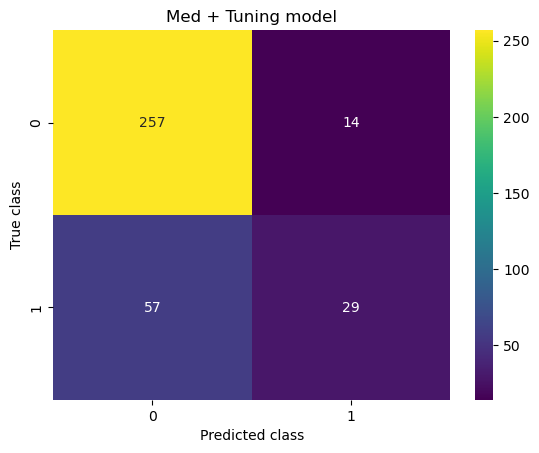

In [19]:
# GridSearchCV를 이용한 튜닝
grid_search_MW = GridSearchCV(estimator=model_MW, param_grid=param_grid, scoring ='f1', cv=5)
grid_search_MW.fit(X_MED, y_MED)

# 최적의 hypaerparameter로 모델 생성 
best_model_MW = XGBClassifier(**grid_search_MW.best_params_, random_state =42)
print("Best hyperparameters: ", grid_search_MW.best_params_)

# 모델 학습
best_model_MW.fit(X_train_MED, y_train_MED)

# 예측 결과 출력
y_pred_MED = best_model_MW.predict(X_test_MED)
print(classification_report(y_test_MED, y_pred_MED))

# Plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test_MED, y_pred_MED)
sns.heatmap(cm, annot=True, fmt = 'd', cmap="viridis")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Med + Tuning model")
plt.show()

## AUROC 

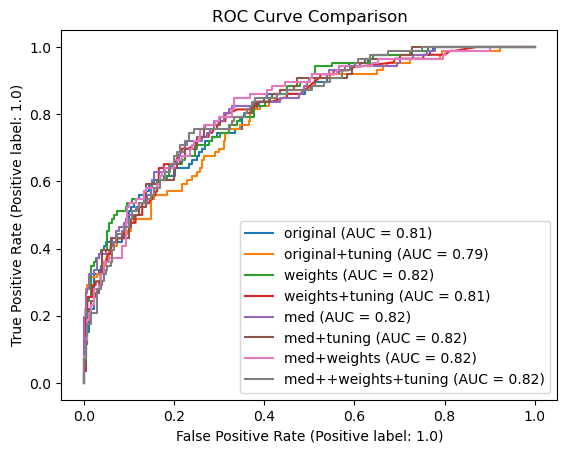

Original's AUC:  0.8122800995451815
Original + Tuning's AUC:  0.7940873594782459
Weights's AUC:  0.8238221917102891
Weights + Tuning's AUC:  0.8129666180382734
Med's AUC:  0.8211190251437398
Med + Tuning's AUC:  0.8166137475328242
Med + Weights's AUC:  0.8185874882004635
Med + Weights + Tuning's AUC:  0.8160130438513686

best model: weights
best score:  0.8238221917102891


In [54]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt 

# 그래프 그리기
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(model_original, X_test, y_test, name= 'original', ax=ax)
RocCurveDisplay.from_estimator(best_model, X_test, y_test, name= 'original+tuning', ax=ax)

RocCurveDisplay.from_estimator(model_weights, X_test, y_test, name= 'weights', ax=ax)
RocCurveDisplay.from_estimator(best_model_wt, X_test, y_test, name= 'weights+tuning', ax=ax)

RocCurveDisplay.from_estimator(model_MED, X_test_MED, y_test_MED, name= 'med', ax=ax)
RocCurveDisplay.from_estimator(best_model_MED, X_test_MED, y_test_MED, name= 'med+tuning', ax=ax)

RocCurveDisplay.from_estimator(model_MW, X_test_MED, y_test_MED, name= 'med+weights', ax=ax)
RocCurveDisplay.from_estimator(best_model_MW, X_test_MED, y_test_MED, name= 'med++weights+tuning', ax=ax)

ax.set_title('ROC Curve Comparison')
ax.legend()
plt.show()


y_pred_proba1 = model_original.predict_proba(X_test)[:, 1]
auc1 = roc_auc_score(y_test, y_pred_proba1)
print("Original's AUC: ", auc1)
y_pred_proba2 = best_model.predict_proba(X_test)[:, 1]
auc2 = roc_auc_score(y_test, y_pred_proba2)
print("Original + Tuning's AUC: ", auc2)


y_pred_proba3 = model_weights.predict_proba(X_test)[:, 1]
auc3 = roc_auc_score(y_test, y_pred_proba3)
print("Weights's AUC: ", auc3)
y_pred_proba4 = best_model_wt.predict_proba(X_test)[:, 1]
auc4 = roc_auc_score(y_test, y_pred_proba4)
print("Weights + Tuning's AUC: ", auc4)


y_pred_proba5 = model_MED.predict_proba(X_test_MED)[:, 1]
auc5 = roc_auc_score(y_test_MED, y_pred_proba5)
print("Med's AUC: ", auc5)
y_pred_proba6 = best_model_MED.predict_proba(X_test_MED)[:, 1]
auc6 = roc_auc_score(y_test_MED, y_pred_proba6)
print("Med + Tuning's AUC: ", auc6)


y_pred_proba7 = model_MW.predict_proba(X_test_MED)[:, 1]
auc7 = roc_auc_score(y_test_MED, y_pred_proba7)
print("Med + Weights's AUC: ", auc7)
y_pred_proba8 = best_model_MW.predict_proba(X_test_MED)[:, 1]
auc8 = roc_auc_score(y_test_MED, y_pred_proba8)
print("Med + Weights + Tuning's AUC: ", auc8)


#### 
print("")
max_score = max(auc1, auc2, auc3, auc4, auc5, auc6, auc7, auc8)

if max_score == auc1:
    print("best model: original")
elif max_score == auc2:
    print("best model: original+tuning")
elif max_score == auc3:
    print("best model: weights")
elif max_score == auc4:
    print("best model: weights+tuning")
elif max_score == auc5:
    print("best model: med")
elif max_score == auc6:
    print("best model: med+tuning")
elif max_score == auc7:
    print("best model: med+wieghts")
else:
    print("best model: med+wieghts+tuning")


print("best score: ", max_score )